 # Custom training with tf.distribute.Strategy

In [43]:
# Import TensorFlow
import tensorflow as tf
import h5py
import math
import pandas as pd
# Helper libraries
import numpy as np
from numpy.lib.stride_tricks import as_strided
from itertools import chain
import os
import random
import pyarrow as pa
import pyarrow.parquet as pq
print(tf.__version__)
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, Conv2D, MaxPooling2D, Reshape
from keras.optimizers import SGD
from keras import optimizers
from tensorflow.keras import layers
from tensorflow import  keras
import keras
import keras.backend as K
import matplotlib.pyplot as plt
import matplotlib
#tf.enable_eager_execution()

2.10.0


## Create a strategy to distribute the variables and the graph

In [44]:
# If the list of devices is not specified in
# `tf.distribute.MirroredStrategy` constructor, they will be auto-detected.
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [45]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [255]:
tf.compat.v1.enable_eager_execution()


# Splitting data by Turbofan Unit

## Defining IDS per node

In [132]:
NUMBER_OF_DATASET = 4
FEATURES_PERCENTAGE = 1
VAL_PERCENTAGE = 0.85
BATCH_SIZE = 128
EPOCHS = 540
LEARNING_RATE = 0.01
OUT_PATH = "data/cmapss/processed/"
train_df = pq.read_table(OUT_PATH + 'train_fd00' + str(NUMBER_OF_DATASET)+'.parquet').to_pandas()

In [133]:
# Naming columns to training the model 
SENSOR_COLS = ['s2','s3','s4','s5','s6','s7', 's8','s9','s11','s12','s13','s14','s15','s17','s20','s21']
SEQUENCE_COLS = ['RUL']
TARGET_COLS = ['RUL']
SEQUENCE_COLS.extend(SENSOR_COLS)


In [134]:
SEED=10
NODES=4

random.seed(SEED)
ENGINES = 248
ids = [*range(1,ENGINES+1)]
random.shuffle(ids)
training_ids = ids[:int(len(ids)*VAL_PERCENTAGE)] 
validation_ids = ids[int(len(ids)*VAL_PERCENTAGE):int(len(ids))]
 
#IDS_NODES_TRAIN=[training_ids[x:x+(len(training_ids)+1)//NODES] for x in range(0, len(training_ids)+1, (len(training_ids)+1)//NODES)]
#IDS_NODES_TEST=[validation_ids[x:x+(len(validation_ids)+1)//NODES] for x in range(0, len(validation_ids)+1, (len(validation_ids)+1)//NODES)]
        
IDS_NODES_TRAIN=[ids[:int(len(ids)*VAL_PERCENTAGE)],ids[:int(len(ids)*VAL_PERCENTAGE)],ids[:int(len(ids)*VAL_PERCENTAGE)],ids[:int(len(ids)*VAL_PERCENTAGE)]]
IDS_NODES_TEST=[ids[int(len(ids)*VAL_PERCENTAGE):int(len(ids))],ids[int(len(ids)*VAL_PERCENTAGE):int(len(ids))],ids[int(len(ids)*VAL_PERCENTAGE):int(len(ids))],ids[int(len(ids)*VAL_PERCENTAGE):int(len(ids))]]

## Split data and send Labels to Server

In [135]:
M_LABELS=[*range(0,NODES)]
MAX_DATASET_SIZE=0

for node in range(0,NODES):
    data_node = IDS_NODES_TRAIN[node]
    #random.shuffle(SEQUENCE_COLS)
    sequence_cols_ = SEQUENCE_COLS[:int(len(SEQUENCE_COLS)*FEATURES_PERCENTAGE)]
                
    for x in range(len(data_node)):
        data_trajectory = train_df.loc[train_df['id'] == data_node[x]]
        # Get X and Y data
        if x == 0:
            _train=data_trajectory[sequence_cols_]
        if x != 0:
            _train=_train.append(data_trajectory[sequence_cols_],ignore_index=True)
        if x == len(data_node)-1:
            _train=_train.sample(frac=1, random_state=SEED).reset_index(drop=True)
            X_train=_train[SENSOR_COLS]
            y_train=_train[TARGET_COLS]
            M_LABELS[node]=np.round(y_train.to_numpy(), 3).tolist()
            if (MAX_DATASET_SIZE<y_train.to_numpy().size):
                MAX_DATASET_SIZE=y_train.to_numpy().size

In [136]:
M=np.empty((MAX_DATASET_SIZE,NODES))
print(M.shape)
M[:] = np.nan
for x in range(0,NODES):
    M[:len(M_LABELS[x]),x]=list(chain.from_iterable(M_LABELS[x]))

(51641, 4)


# Calculaling Label Matrix for first Lab (node)

In [137]:
import operator
def labelSynchronization(M, localLab):
    numWorkers = len(list(zip(*M)))
    ID=list(np.unique(M[:,0]))
    synchronizedLabels=np.zeros(M.shape,dtype=int)
    synchronizedLabels[:,localLab]=range(1,len(M)+1);
    if(numWorkers>1):
        labelsAndCounters=np.zeros((len(ID),numWorkers))
        for worker in range(0,numWorkers):
            for _id in range(0,len(ID)):
                labelsAndCounters[_id,worker]=operator.countOf(M[:,worker].tolist(),ID[_id])
        for worker in range(0,numWorkers):
            if worker!=localLab:
                counterPerLabel=np.zeros((len(ID),numWorkers), dtype=int)
                for _id in range(0, len(ID)):
                    element=np.where(M[:, worker]== ID[_id])
                    for row in range(0, len(M)):
                        if (M[row,localLab]== ID[_id]):
                            synchronizedLabels[row,worker]=(list(element)[0])[counterPerLabel[_id,numWorkers-1]]+1
                            counterPerLabel[_id,numWorkers-1] += 1
                            if counterPerLabel[_id,numWorkers-1]>len(element):
                                counterPerLabel[_id,numWorkers-1]=1
    return synchronizedLabels


SYNCHRONIZED_LABELS=labelSynchronization(M, 0)-1

In [138]:
SYNCHRONIZED_LABELS

array([[    0,     0,     0,     0],
       [    1,     1,     1,     1],
       [    2,     2,     2,     2],
       ...,
       [51638,     1,     1,     1],
       [51639,  1256,  1256,  1256],
       [51640,     1,     1,     1]])

## Setup input pipeline

In [139]:
def read_h5_file(resources_path, name):
    # Read numpy array 
    hf = h5py.File(resources_path+name+"-centralized.h5", 'r')
    return np.array(hf[name][:])

In [140]:
nodes = [0,1,2,3] 
model = "mlp"

In [141]:
def batch_data(test, batch_size):
    m,n = test.shape
    S = test.itemsize
    if not batch_size:
        batch_size = m
    count_batches = m//batch_size
    # Batches which can be covered fully
    test_batches = as_strided(test, shape=(count_batches, batch_size, n), strides=(batch_size*n*S,n*S,S)).copy()
    covered = count_batches*batch_size
    if covered < m:
        rest = test[covered:,:]
        rm, rn = rest.shape
        mismatch = batch_size - rm
        last_batch = np.vstack((rest,np.zeros((mismatch,rn)))).reshape(1,-1,n)
        return np.vstack((test_batches,last_batch))
    return test_batches

In [142]:
def fn_data_partition(df,IDS_NODES,test):
    distributedData=[]
    for replica in range(0, NODES):
        DATA_REPLICA_ID = []
        for data_node in IDS_NODES:
            routes_ = {}
            random.shuffle(SEQUENCE_COLS)
            sequence_cols_ = SEQUENCE_COLS[:int(len(SEQUENCE_COLS)*FEATURES_PERCENTAGE)]
            _ids = ids[:int(len(data_node))] 
            for x in range(len(_ids)):
                data_trajectory = df.loc[df['id'] == _ids[x]]
                # Get X and Y data
                if x == 0:
                    _data=data_trajectory[SEQUENCE_COLS] 
                if x != 0:
                    _data=_data.append(data_trajectory[SEQUENCE_COLS],ignore_index=True)
                if x == len(_ids)-1:
                    _data=_data.sample(frac=1, random_state=SEED).reset_index(drop=True)
        X_=_data[SENSOR_COLS].to_numpy()
        y_=_data[TARGET_COLS].to_numpy()
        if (test==False):
            X_=X_[SYNCHRONIZED_LABELS[:,replica]][:,:]
            y_=y_[SYNCHRONIZED_LABELS[:,replica]][:,:]
        
        X_=batch_data(X_,BATCH_SIZE)
        y_=batch_data(y_,BATCH_SIZE)
        for i in range(0,len(y_)):
            DATA_REPLICA_ID.append((tf.convert_to_tensor(X_[i], dtype=tf.float32),tf.convert_to_tensor(y_[i], dtype=tf.float32)))
        distributedData.append(DATA_REPLICA_ID)
    return distributedData

In [143]:
train_df = pq.read_table(OUT_PATH + 'train_fd00' + str(NUMBER_OF_DATASET)+'.parquet').to_pandas()
distributedDataTrain = fn_data_partition(train_df,IDS_NODES_TRAIN, False)
distributedDataTest = fn_data_partition(train_df,IDS_NODES_TEST, True)

In [144]:
def value_fn_train(ctx):
    return distributedDataTrain[ctx.replica_id_in_sync_group]
def value_fn_test(ctx):
    return distributedDataTrain[ctx.replica_id_in_sync_group]

In [145]:
distributed_values_train = strategy.experimental_distribute_values_from_function(value_fn_train)
distributed_values_test = strategy.experimental_distribute_values_from_function(value_fn_test)

local_result_train = strategy.experimental_local_results(distributed_values_train)[0]
local_result_test = strategy.experimental_local_results(distributed_values_test)[0]

# Create Model

In [146]:
 def create_model_mlp(input_signals):
    model = Sequential()
    model.add(Dense(10, activation="sigmoid", input_shape=(input_signals,)))
    model.add(Dense(1, activation='relu'))
    #model.compile(loss=rmse,optimizer=optimizer,metrics=['mae','mse',rmse])
    return model

In [147]:
# Create a checkpoint directory to store the checkpoints.
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

## Define the loss function

Recall that the loss function consists of one or two parts:

  * The **prediction loss** measures how far off the model's predictions are from the training labels for a batch of training examples. It is computed for each labeled example and then reduced across the batch by computing the average value.
  * Optionally, **regularization loss** terms can be added to the prediction loss, to steer the model away from overfitting the training data. A common choice is L2 regularization, which adds a small fixed multiple of the sum of squares of all model weights, independent of the number of examples. The model above uses L2 regularization to demonstrate its handling in the training loop below.

For training on a single machine with a single GPU/CPU, this works as follows:

  * The prediction loss is computed for each example in the batch, summed across the batch, and then divided by the batch size.
  * The regularization loss is added to the prediction loss.
  * The gradient of the total loss is computed w.r.t. each model weight, and the optimizer updates each model weight from the corresponding gradient.

With `tf.distribute.Strategy`, the input batch is split between replicas.
For example, let's say you have 4 GPUs, each with one replica of the model. One batch of 256 input examples is distributed evenly across the 4 replicas, so each replica gets a batch of size 64: We have `256 = 4*64`, or generally `GLOBAL_BATCH_SIZE = num_replicas_in_sync * BATCH_SIZE_PER_REPLICA`.

Each replica computes the loss from the training examples it gets and computes the gradients of the loss w.r.t. each model weight. The optimizer takes care that these **gradients are summed up across replicas** before using them to update the copies of the model weights on each replica.

*So, how should the loss be calculated when using a `tf.distribute.Strategy`?*

  * Each replica computes the prediction loss for all examples distributed to it, sums up the results and divides them by `num_replicas_in_sync * BATCH_SIZE_PER_REPLICA`, or equivently, `GLOBAL_BATCH_SIZE`.
  * Each replica compues the regularization loss(es) and divides them by
  `num_replicas_in_sync`.

Compared to non-distributed training, all per-replica loss terms are scaled down by a factor of `1/num_replicas_in_sync`. On the other hand, all loss terms -- or rather, their gradients -- are summed across that number of replicas before the optimizer applies them. In effect, the optimizer on each replica uses the same gradients as if a non-distributed computation with `GLOBAL_BATCH_SIZE` had happened. This is consistent with the distributed and undistributed behavior of Keras `Model.fit`. See the [Distributed training with Keras](./keras.ipynb) tutorial on how a larger gloabl batch size enables to scale up the learning rate.

In [295]:
with strategy.scope():
    def compute_loss_batch(labels, predictions, model_losses):
        per_example_loss = (labels - predictions)**2  # Sample error
        loss = tf.math.sqrt(tf.nn.compute_average_loss(per_example_loss)) # Batch Error
        return loss

In [296]:
with strategy.scope():
    test_mae = tf.keras.metrics.MeanAbsoluteError()
    train_rmse = tf.keras.metrics.RootMeanSquaredError()
    test_rmse = tf.keras.metrics.RootMeanSquaredError()

In [297]:
# A model, an optimizer, and a checkpoint must be created under `strategy.scope`.
with strategy.scope():
    model = create_model_mlp(16)
    optimizer = SGD(lr=LEARNING_RATE)
    checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

In [304]:
def train_step_batch(inputs):
    input_signals, labels = inputs
    with tf.GradientTape() as tape:
        predictions = model(input_signals, training=True)
        loss = compute_loss_batch(labels, predictions, model.losses) # Batch Error
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_rmse.update_state(labels, predictions)
    return loss
def train_step_sample(inputs):
    input_signals, labels = inputs
    with tf.GradientTape() as tape:
        predictions = model(input_signals, training=True)
    return predictions

def compute_loss_fedLabSync(inputs, collaborativePredictions):
    input_signals, labels = inputs
    with tf.GradientTape() as tape:
        predictions = model(input_signals, training=True)
        loss = compute_loss_batch(labels, (collaborativePredictions+predictions)/2, model.losses) # Batch Error
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_rmse.update_state(labels, (collaborativePredictions+predictions)/2)
    return loss
    
def test_step(inputs):
    input_signals, labels = inputs
    predictions = model(input_signals, training=False)
    
    t_loss = tf.math.abs(labels-predictions)
    test_mae.update_state(labels, predictions)
    test_rmse.update_state(labels, predictions)

In [308]:
# with the distributed input.
@tf.function
def distributed_train_step_batch(dataset_inputs):
    per_replica_losses = strategy.run(train_step_batch, args=(dataset_inputs,)) 
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,
                         axis=None)
@tf.function
def collaborative_predictions(dataset_inputs):
    per_replica_predictions= strategy.run(train_step_sample, args=(dataset_inputs,))
    return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_predictions,  
                         axis=None)
@tf.function
def local_collaborative_loss(collaborative_predictions, dataset_inputs):
    return strategy.run(compute_loss_fedLabSync, args=(dataset_inputs, collaborative_predictions,))


for epoch in range(EPOCHS):
    # TRAIN LOOP
    total_loss = 0.0
    #num_batches = 0
    for x in local_result_train:
        colaboratePrediction = collaborative_predictions(x)
        total_loss += local_collaborative_loss(colaboratePrediction, x)
        #total_loss += distributed_train_step_batch(x)
        num_batches += 1
    train_loss = total_loss / num_batches
    
    # TEST LOOP
    for x in local_result_test:
        distributed_test_step_batch(x)

    if epoch % 2 == 0:
        checkpoint.save(checkpoint_prefix)

    template = ("Epoch {}, Train_RMSE: {}, Test MAE: {}, "
              "Test_RMSE: {}")
    print(template.format(epoch + 1, train_rmse.result(), test_mae.result(),
                         test_rmse.result()))
    test_mae.reset_states()
    train_rmse.reset_states()
    test_rmse.reset_states()

Epoch 1, Train_RMSE: 0.2896575331687927, Test MAE: 0.1990937888622284, Test_RMSE: 0.24162410199642181
Epoch 2, Train_RMSE: 0.23430991172790527, Test MAE: 0.18677197396755219, Test_RMSE: 0.22944457828998566
Epoch 3, Train_RMSE: 0.2262091338634491, Test MAE: 0.18200354278087616, Test_RMSE: 0.22376202046871185
Epoch 4, Train_RMSE: 0.22158987820148468, Test MAE: 0.17897269129753113, Test_RMSE: 0.21997052431106567
Epoch 5, Train_RMSE: 0.21833057701587677, Test MAE: 0.17675194144248962, Test_RMSE: 0.2171596735715866
Epoch 6, Train_RMSE: 0.21584652364253998, Test MAE: 0.17500805854797363, Test_RMSE: 0.21495948731899261
Epoch 7, Train_RMSE: 0.21386830508708954, Test MAE: 0.17356808483600616, Test_RMSE: 0.21317614614963531
Epoch 8, Train_RMSE: 0.2122470736503601, Test MAE: 0.17233848571777344, Test_RMSE: 0.21169735491275787
Epoch 9, Train_RMSE: 0.21089135110378265, Test MAE: 0.1712726205587387, Test_RMSE: 0.21044936776161194
Epoch 10, Train_RMSE: 0.20973818004131317, Test MAE: 0.170332312583923

Epoch 80, Train_RMSE: 0.18652991950511932, Test MAE: 0.14168138802051544, Test_RMSE: 0.18660052120685577
Epoch 81, Train_RMSE: 0.18639349937438965, Test MAE: 0.14151357114315033, Test_RMSE: 0.18646547198295593
Epoch 82, Train_RMSE: 0.1862586885690689, Test MAE: 0.14135150611400604, Test_RMSE: 0.18633297085762024
Epoch 83, Train_RMSE: 0.18612585961818695, Test MAE: 0.14118705689907074, Test_RMSE: 0.1862003654241562
Epoch 84, Train_RMSE: 0.1859944611787796, Test MAE: 0.14102225005626678, Test_RMSE: 0.1860693097114563
Epoch 85, Train_RMSE: 0.18586470186710358, Test MAE: 0.14086201786994934, Test_RMSE: 0.18593978881835938
Epoch 86, Train_RMSE: 0.18573661148548126, Test MAE: 0.14070282876491547, Test_RMSE: 0.18581180274486542
Epoch 87, Train_RMSE: 0.18560989201068878, Test MAE: 0.14054761826992035, Test_RMSE: 0.1856852024793625
Epoch 88, Train_RMSE: 0.18548458814620972, Test MAE: 0.14039510488510132, Test_RMSE: 0.18556001782417297
Epoch 89, Train_RMSE: 0.1853606402873993, Test MAE: 0.140245

Epoch 159, Train_RMSE: 0.17827896773815155, Test MAE: 0.13265156745910645, Test_RMSE: 0.17838507890701294
Epoch 160, Train_RMSE: 0.17819593846797943, Test MAE: 0.13257497549057007, Test_RMSE: 0.1783032864332199
Epoch 161, Train_RMSE: 0.17811386287212372, Test MAE: 0.13249655067920685, Test_RMSE: 0.17822222411632538
Epoch 162, Train_RMSE: 0.17803265154361725, Test MAE: 0.1324177384376526, Test_RMSE: 0.1781420111656189
Epoch 163, Train_RMSE: 0.177952378988266, Test MAE: 0.13234111666679382, Test_RMSE: 0.17806264758110046
Epoch 164, Train_RMSE: 0.17787308990955353, Test MAE: 0.13226404786109924, Test_RMSE: 0.1779841184616089
Epoch 165, Train_RMSE: 0.17779456079006195, Test MAE: 0.13218912482261658, Test_RMSE: 0.17790618538856506
Epoch 166, Train_RMSE: 0.17771655321121216, Test MAE: 0.13211411237716675, Test_RMSE: 0.17782916128635406
Epoch 167, Train_RMSE: 0.1776396632194519, Test MAE: 0.13203848898410797, Test_RMSE: 0.1777530014514923
Epoch 168, Train_RMSE: 0.17756380140781403, Test MAE: 

Epoch 237, Train_RMSE: 0.17392095923423767, Test MAE: 0.12849216163158417, Test_RMSE: 0.17405876517295837
Epoch 238, Train_RMSE: 0.17388220131397247, Test MAE: 0.12845931947231293, Test_RMSE: 0.17401953041553497
Epoch 239, Train_RMSE: 0.1738436371088028, Test MAE: 0.12842847406864166, Test_RMSE: 0.17398114502429962
Epoch 240, Train_RMSE: 0.17380528151988983, Test MAE: 0.1283964067697525, Test_RMSE: 0.17394299805164337
Epoch 241, Train_RMSE: 0.1737670749425888, Test MAE: 0.1283692717552185, Test_RMSE: 0.17390505969524384
Epoch 242, Train_RMSE: 0.17372895777225494, Test MAE: 0.12833714485168457, Test_RMSE: 0.17386756837368011
Epoch 243, Train_RMSE: 0.17369112372398376, Test MAE: 0.12830740213394165, Test_RMSE: 0.17383000254631042
Epoch 244, Train_RMSE: 0.173653706908226, Test MAE: 0.12827813625335693, Test_RMSE: 0.17379267513751984
Epoch 245, Train_RMSE: 0.173616424202919, Test MAE: 0.1282494068145752, Test_RMSE: 0.17375552654266357
Epoch 246, Train_RMSE: 0.17357951402664185, Test MAE: 0

Epoch 315, Train_RMSE: 0.17143985629081726, Test MAE: 0.1265629082918167, Test_RMSE: 0.17159110307693481
Epoch 316, Train_RMSE: 0.1714138239622116, Test MAE: 0.12653887271881104, Test_RMSE: 0.1715657114982605
Epoch 317, Train_RMSE: 0.17138810455799103, Test MAE: 0.12651686370372772, Test_RMSE: 0.1715400218963623
Epoch 318, Train_RMSE: 0.17136245965957642, Test MAE: 0.12649458646774292, Test_RMSE: 0.17151451110839844
Epoch 319, Train_RMSE: 0.17133702337741852, Test MAE: 0.12647294998168945, Test_RMSE: 0.17148913443088531
Epoch 320, Train_RMSE: 0.17131158709526062, Test MAE: 0.12644991278648376, Test_RMSE: 0.171463742852211
Epoch 321, Train_RMSE: 0.1712861955165863, Test MAE: 0.12642797827720642, Test_RMSE: 0.17143860459327698
Epoch 322, Train_RMSE: 0.17126113176345825, Test MAE: 0.12640374898910522, Test_RMSE: 0.17141343653202057
Epoch 323, Train_RMSE: 0.17123593389987946, Test MAE: 0.12638144195079803, Test_RMSE: 0.1713884174823761
Epoch 324, Train_RMSE: 0.17121131718158722, Test MAE: 

Epoch 394, Train_RMSE: 0.1697535514831543, Test MAE: 0.12489716708660126, Test_RMSE: 0.16991625726222992
Epoch 395, Train_RMSE: 0.16973701119422913, Test MAE: 0.12487239390611649, Test_RMSE: 0.16989971697330475
Epoch 396, Train_RMSE: 0.16972045600414276, Test MAE: 0.12485463917255402, Test_RMSE: 0.16988323628902435
Epoch 397, Train_RMSE: 0.16970409452915192, Test MAE: 0.12483719736337662, Test_RMSE: 0.16986675560474396
Epoch 398, Train_RMSE: 0.169687882065773, Test MAE: 0.12482089549303055, Test_RMSE: 0.16985058784484863
Epoch 399, Train_RMSE: 0.16967181861400604, Test MAE: 0.12480100244283676, Test_RMSE: 0.1698344200849533
Epoch 400, Train_RMSE: 0.16965563595294952, Test MAE: 0.12478309869766235, Test_RMSE: 0.16981840133666992
Epoch 401, Train_RMSE: 0.16963955760002136, Test MAE: 0.12476504594087601, Test_RMSE: 0.1698027402162552
Epoch 402, Train_RMSE: 0.16962367296218872, Test MAE: 0.12474755942821503, Test_RMSE: 0.16978685557842255
Epoch 403, Train_RMSE: 0.16960790753364563, Test MA

Epoch 472, Train_RMSE: 0.1687324345111847, Test MAE: 0.12388008087873459, Test_RMSE: 0.16889722645282745
Epoch 473, Train_RMSE: 0.16872215270996094, Test MAE: 0.12387107312679291, Test_RMSE: 0.16888682544231415
Epoch 474, Train_RMSE: 0.16871167719364166, Test MAE: 0.12386107444763184, Test_RMSE: 0.16887660324573517
Epoch 475, Train_RMSE: 0.16870151460170746, Test MAE: 0.12385261058807373, Test_RMSE: 0.1688663810491562
Epoch 476, Train_RMSE: 0.16869129240512848, Test MAE: 0.1238444373011589, Test_RMSE: 0.1688561737537384
Epoch 477, Train_RMSE: 0.16868111491203308, Test MAE: 0.12383559346199036, Test_RMSE: 0.168845996260643
Epoch 478, Train_RMSE: 0.16867105662822723, Test MAE: 0.1238265112042427, Test_RMSE: 0.16883577406406403
Epoch 479, Train_RMSE: 0.168660968542099, Test MAE: 0.12381748855113983, Test_RMSE: 0.1688256412744522
Epoch 480, Train_RMSE: 0.16865086555480957, Test MAE: 0.1238086149096489, Test_RMSE: 0.1688155233860016
Epoch 481, Train_RMSE: 0.16864092648029327, Test MAE: 0.12

# Test

In [309]:
routes_test = {}
test_df = pq.read_table(OUT_PATH + 'test_fd00' + str(NUMBER_OF_DATASET)+'.parquet').to_pandas()
for unit_nr in test_df['id'].unique():
    routes_test[unit_nr-1] = test_df.loc[test_df['id'] == unit_nr]
RC=120

In [310]:
TRAJECTORY=1

5/5 [==============================] - 0s 3ms/step


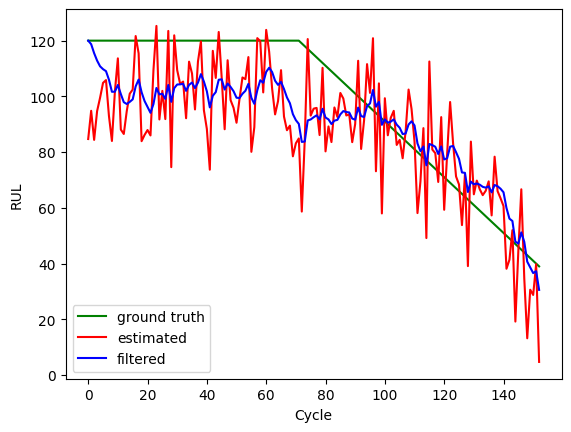

9/9 [==============================] - 0s 2ms/step


7/7 [==============================] - 0s 2ms/step


In [ ]:
routes_kalman = []
rul_predicted=np.array([])
rul_truth=np.array([])
Score=0
#writer = pd.ExcelWriter('RUL_Test_FD004_Turbofan.xlsx', engine='xlsxwriter')
for route_test in routes_test:
    # Define a dictionary containing Students data 
    data = {} 
    # Convert the dictionary into DataFrame 
    df = pd.DataFrame(data)
    #Obtaining rul - groud truth
    truth_dataframe=routes_test[route_test]['RUL']
    truth=np.array(truth_dataframe.values.tolist())*RC
    rul_truth=np.append(rul_truth,truth)
    #Obtaining rul - predicted
    trajectory = routes_test[route_test][SENSOR_COLS].to_numpy()
    rul_trajectory=model.predict(trajectory)
    rul_trajectory = pd.DataFrame(rul_trajectory, columns=['rul'])
    z = np.array(rul_trajectory.values.tolist())
    # intial parameters
    n_iter = len(rul_trajectory)
    sz = (len(rul_trajectory),) # size of array
    # process variance
    #Q=1/209
    Q = 1/209
    # allocate space for arrays
    xhat=np.zeros(sz)      # a posteri estimate of x
    P=np.zeros(sz)         # a posteri error estimate
    xhatminus=np.zeros(sz) # a priori estimate of x
    Pminus=np.zeros(sz)    # a priori error estimate
    K=np.zeros(sz)         # gain or blending factor

    R = 0.3**2 # estimate of measurement variance, change to see effect
    # intial guesses
    #xhat[0] = 1
    xhat[0]=truth[0]/RC
    P[0] = 0.0

    for k in range(1,n_iter):
        # time update
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1]+Q
        # measurement update
        K[k] = Pminus[k]/( Pminus[k]+R )
        xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
        P[k] = (1-K[k])*Pminus[k]
        if(xhat[k]-truth[k]<0):
            score=math.exp((truth[k]-xhat[k])/13)-1;
        if (xhat[k]-truth[k]>=0):
            score=math.exp((xhat[k]-truth[k])/10)-1;
        Score=Score+score;
    
    xhat=xhat*RC
    rul_predicted=np.append(rul_predicted,xhat)
    routes_kalman.insert((unit_nr-1),xhat[(len(xhat)-1)])

    if route_test==TRAJECTORY:
        
        plt.figure()
        plt.plot(truth,'g-',label='ground truth')
        plt.plot(z*RC,'r-',label='estimate')
        plt.plot(xhat,'b-',label='a posteri estimate')
        plt.legend(['ground truth','estimated','filtered'])
        #plt.title('RUL vs cycle', fontweight='bold')
        plt.xlabel('Cycle')
        plt.ylabel('RUL')
        plt.show()
#writer.save()

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
mae=mean_absolute_error(rul_predicted,rul_truth)
mse=mean_squared_error(rul_predicted,rul_truth)
rmse=np.sqrt(mse)
print("GAUSSIAN KALMAN")
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)
#print("Score:",Score)